### DHT/MHT Timescale Plots, 

loading from /g/data temp files

split into different SF and MX terms, averaged over 10 years

Note terms that use daily data have fewer terms due to the computational cost of computing them all. To see the results for less time (1 year average) but more terms, see `Analysis/old/Plotting_DHT_MHT.ipynb`


In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import pandas as pd
import cftime
import IPython.display
import cmocean as cm
import cartopy.crs as ccrs
import cartopy.feature as cft
import sys, os
import warnings
warnings.simplefilter("ignore")
from dask.distributed import Client

from xhistogram.xarray import histogram


In [2]:
client = Client(n_workers=8)
client

<Client: 'tcp://127.0.0.1:35037' processes=8 threads=16, memory=250.00 GiB>

In [4]:
## load stuff for grid info

# files:
xch = 1440#*10#2*288
ych = 1080#*10#2*216

folder = '/g/data/e14/cy8964/Post_Process/temp/'

fgrd   = xr.open_dataset(folder + 'ocean_grid.nc').chunk({'yt_ocean':ych/10,'yu_ocean':ych/10,'xt_ocean':xch/10,'xu_ocean':xch/10})
fwmass_m = xr.open_mfdataset(folder + 'output000fwmass_m_copy.nc',combine='by_coords',chunks={'time': 1},decode_times = True).chunk({'time': 1,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})

# ---------------------------------------------------------------------------------- #

# Generate xgcm grid object:
gridwm = Grid(fwmass_m,coords={"x":{"center":"grid_xt_ocean","right":"grid_xu_ocean"},
                             "y":{"center":"grid_yt_ocean","right":"grid_yu_ocean"},
                             "T":{"center":"neutral","outer":"neutralrho_edges"}},periodic=False)
grid2 = Grid(fgrd,coords={"x":{"center":"xt_ocean","right":"xu_ocean"},
                             "y":{"center":"yt_ocean","right":"yu_ocean"}},periodic=False)

# ---------------------------------------------------------------------------------- #

# Some constants:
Cp = 3992.10322329649
rho0 = 1035
dT = (fwmass_m.neutral[1]-fwmass_m.neutral[0]).values

sc_daylength = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

area = fgrd.area_t.rename({'xt_ocean':'grid_xt_ocean','yt_ocean':'grid_yt_ocean'})
dy = grid2.diff(fgrd.yu_ocean,'y',boundary='extend').rename({'yt_ocean':'grid_yt_ocean'})
dx = grid2.diff(fgrd.xu_ocean,'x',boundary='extend').rename({'xt_ocean':'grid_xt_ocean'})
dyt = grid2.diff(fgrd.yu_ocean,'y',boundary='extend')
dxt = grid2.diff(fgrd.xu_ocean,'x',boundary='extend')

### Load 3d (x,y,temp) data separated by timescale

In [3]:
folder = '/g/data/e14/cy8964/Post_Process/temp/025deg_10yr_3d/'

True_10year_means = xr.open_mfdataset(folder + 'True_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Mean_10year_means = xr.open_mfdataset(folder + 'Mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Twomo_mean_10year_means = xr.open_mfdataset(folder + '2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
sc_Twomo_mean_10year_means = xr.open_mfdataset(folder + 'sc_2mo_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Tenday_mean_10year_means = xr.open_mfdataset(folder + '10day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10, 'grid_xt_ocean':xch/10})
Oneday_mean_10year_means = xr.open_mfdataset(folder + '1day_mean_10year_means.nc')#.chunk({'grid_yu_ocean':ych/10,'grid_yt_ocean':ych/10,'grid_xt_ocean':xch/10})


### Zonal Mean Plots

In [5]:
def plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(45,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(3,7,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,8)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,9)
    (DataSet.temp_vdiffuse_sbc.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,10)
    (DataSet.sw_heat.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,11)
    (DataSet.frazil_3d.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    ((temp).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')


    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,21)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar2,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

In [21]:
def plot_decomp_3d_to_2d_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(45,20),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    cmap = 'coolwarm'

    plt.subplot(3,7,1)
    (DataSet.Psi.sum('grid_xt_ocean').where(maskPsi==1.)/1.e6).plot.contourf(levels=Psicbar,x='grid_yu_ocean',cbar_kwargs={'label':'Sv'},cmap=cmap)
    plt.title('Streamfunction', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,2)
    (Hf.sum('grid_xt_ocean').where(maskHf==1.)/1.e15).plot.contourf(levels=Hfcbar,x='grid_yu_ocean',cbar_kwargs={'label':'PW'},cmap=cmap)
    plt.title('Heat Function', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,8)
    (DataSet.SF.sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=SFcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')
    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    plt.subplot(3,7,17)
    ((DataSet.temp_nonlocal_KPP).sum('grid_xt_ocean').where(maskSF==1.)/1.e12/dy).plot.contourf(levels=MXcbar,x='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Temperature (degrees C)')
    plt.xlabel('Latitude (degrees N)')

    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

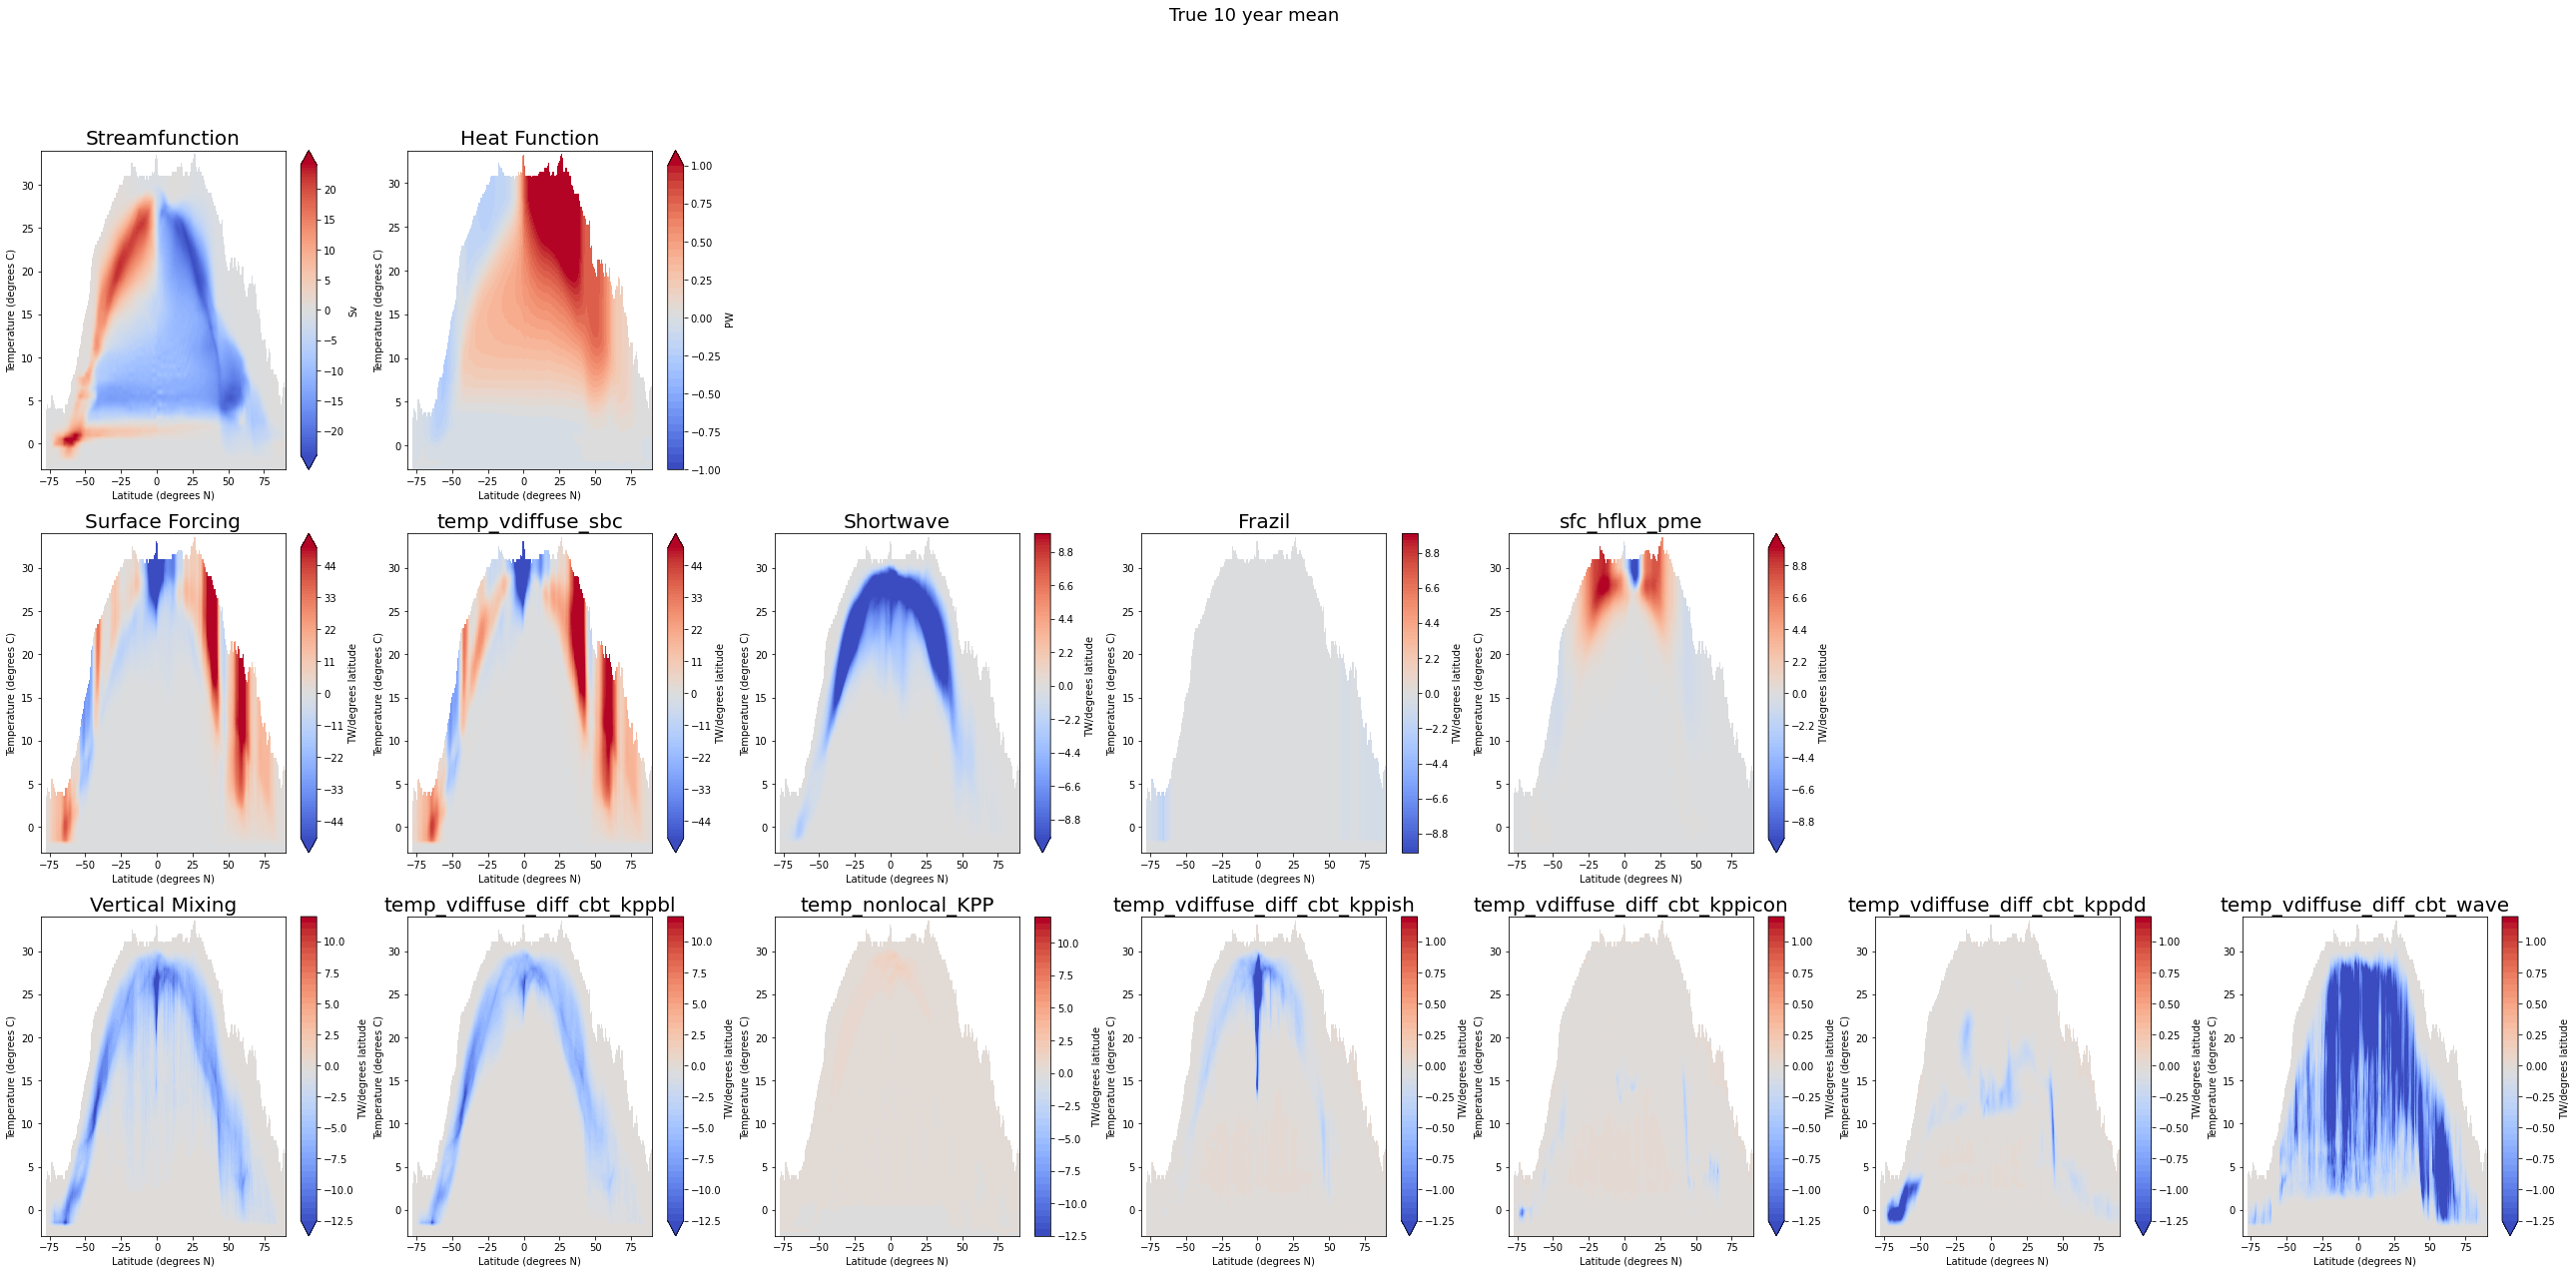

In [6]:
DataSet = True_10year_means
# masking:
maskPsi = 0*True_10year_means.Psi.sum('grid_xt_ocean').where(True_10year_means.Psi.sum('grid_xt_ocean')!=True_10year_means.Psi.sum('grid_xt_ocean').isel(neutralrho_edges=-1))+1.
maskHf = gridwm.interp(maskPsi,'T')
maskSF = gridwm.interp(maskPsi,'y',boundary="fill",fill_value=0.)
maskSF

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)/2
plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/10, 'True 10 year mean')

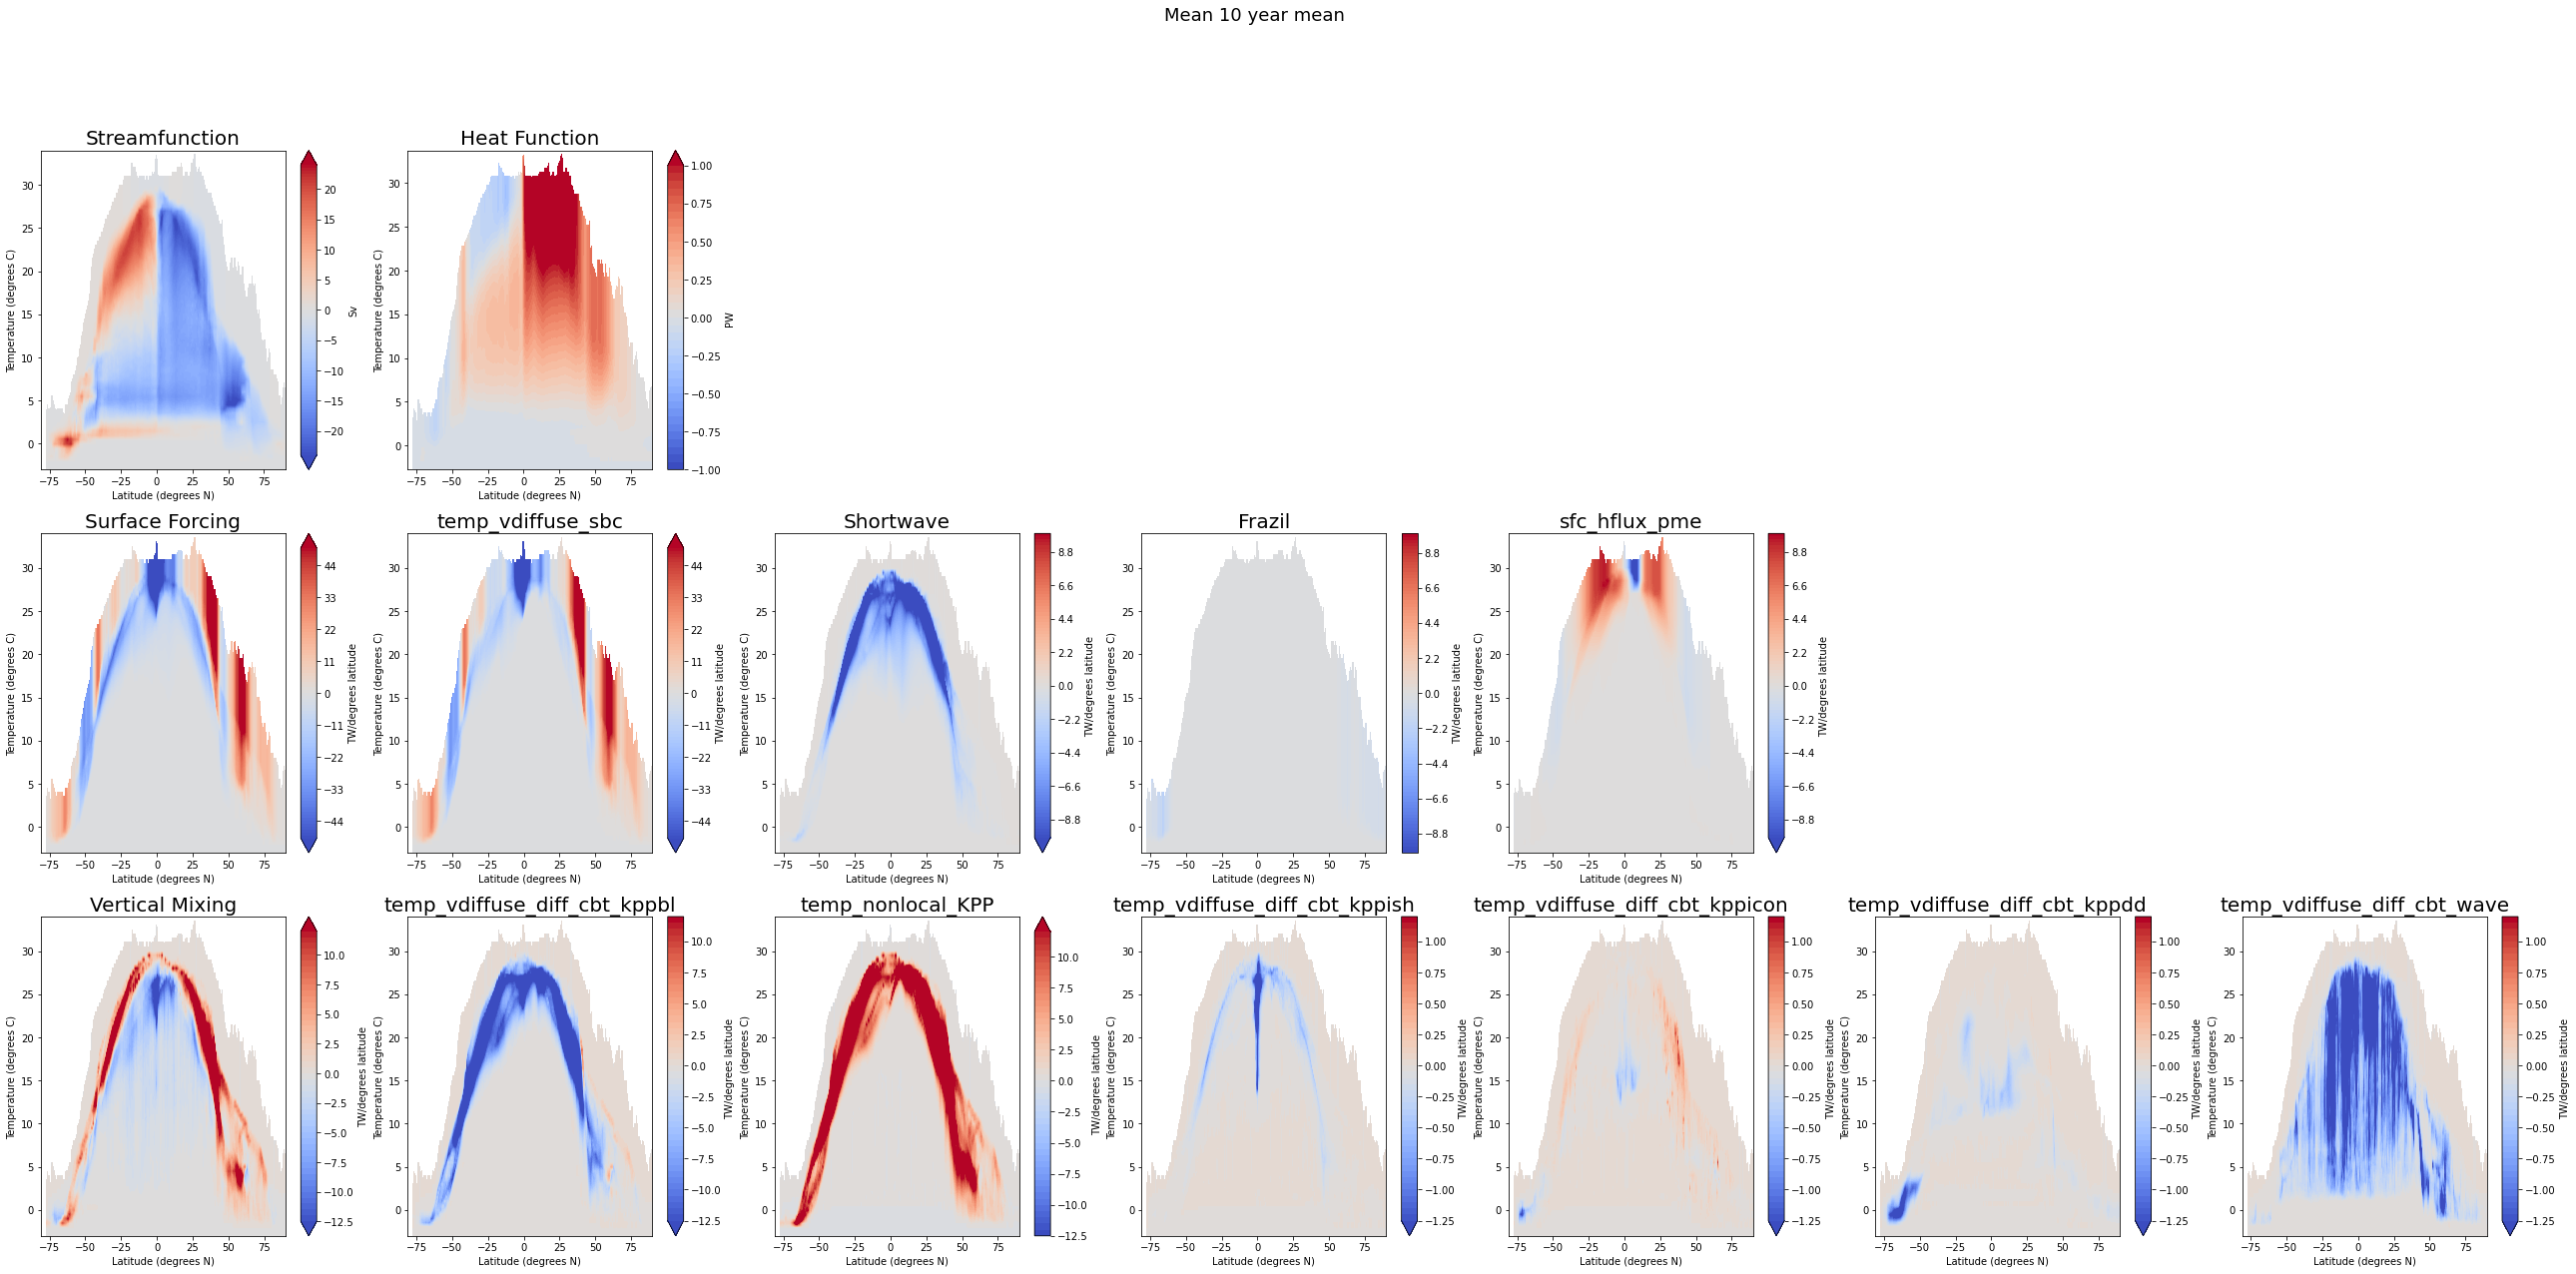

In [7]:
DataSet = Mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)


Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-25.,25.,1.)/2

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/10,  'Mean 10 year mean')

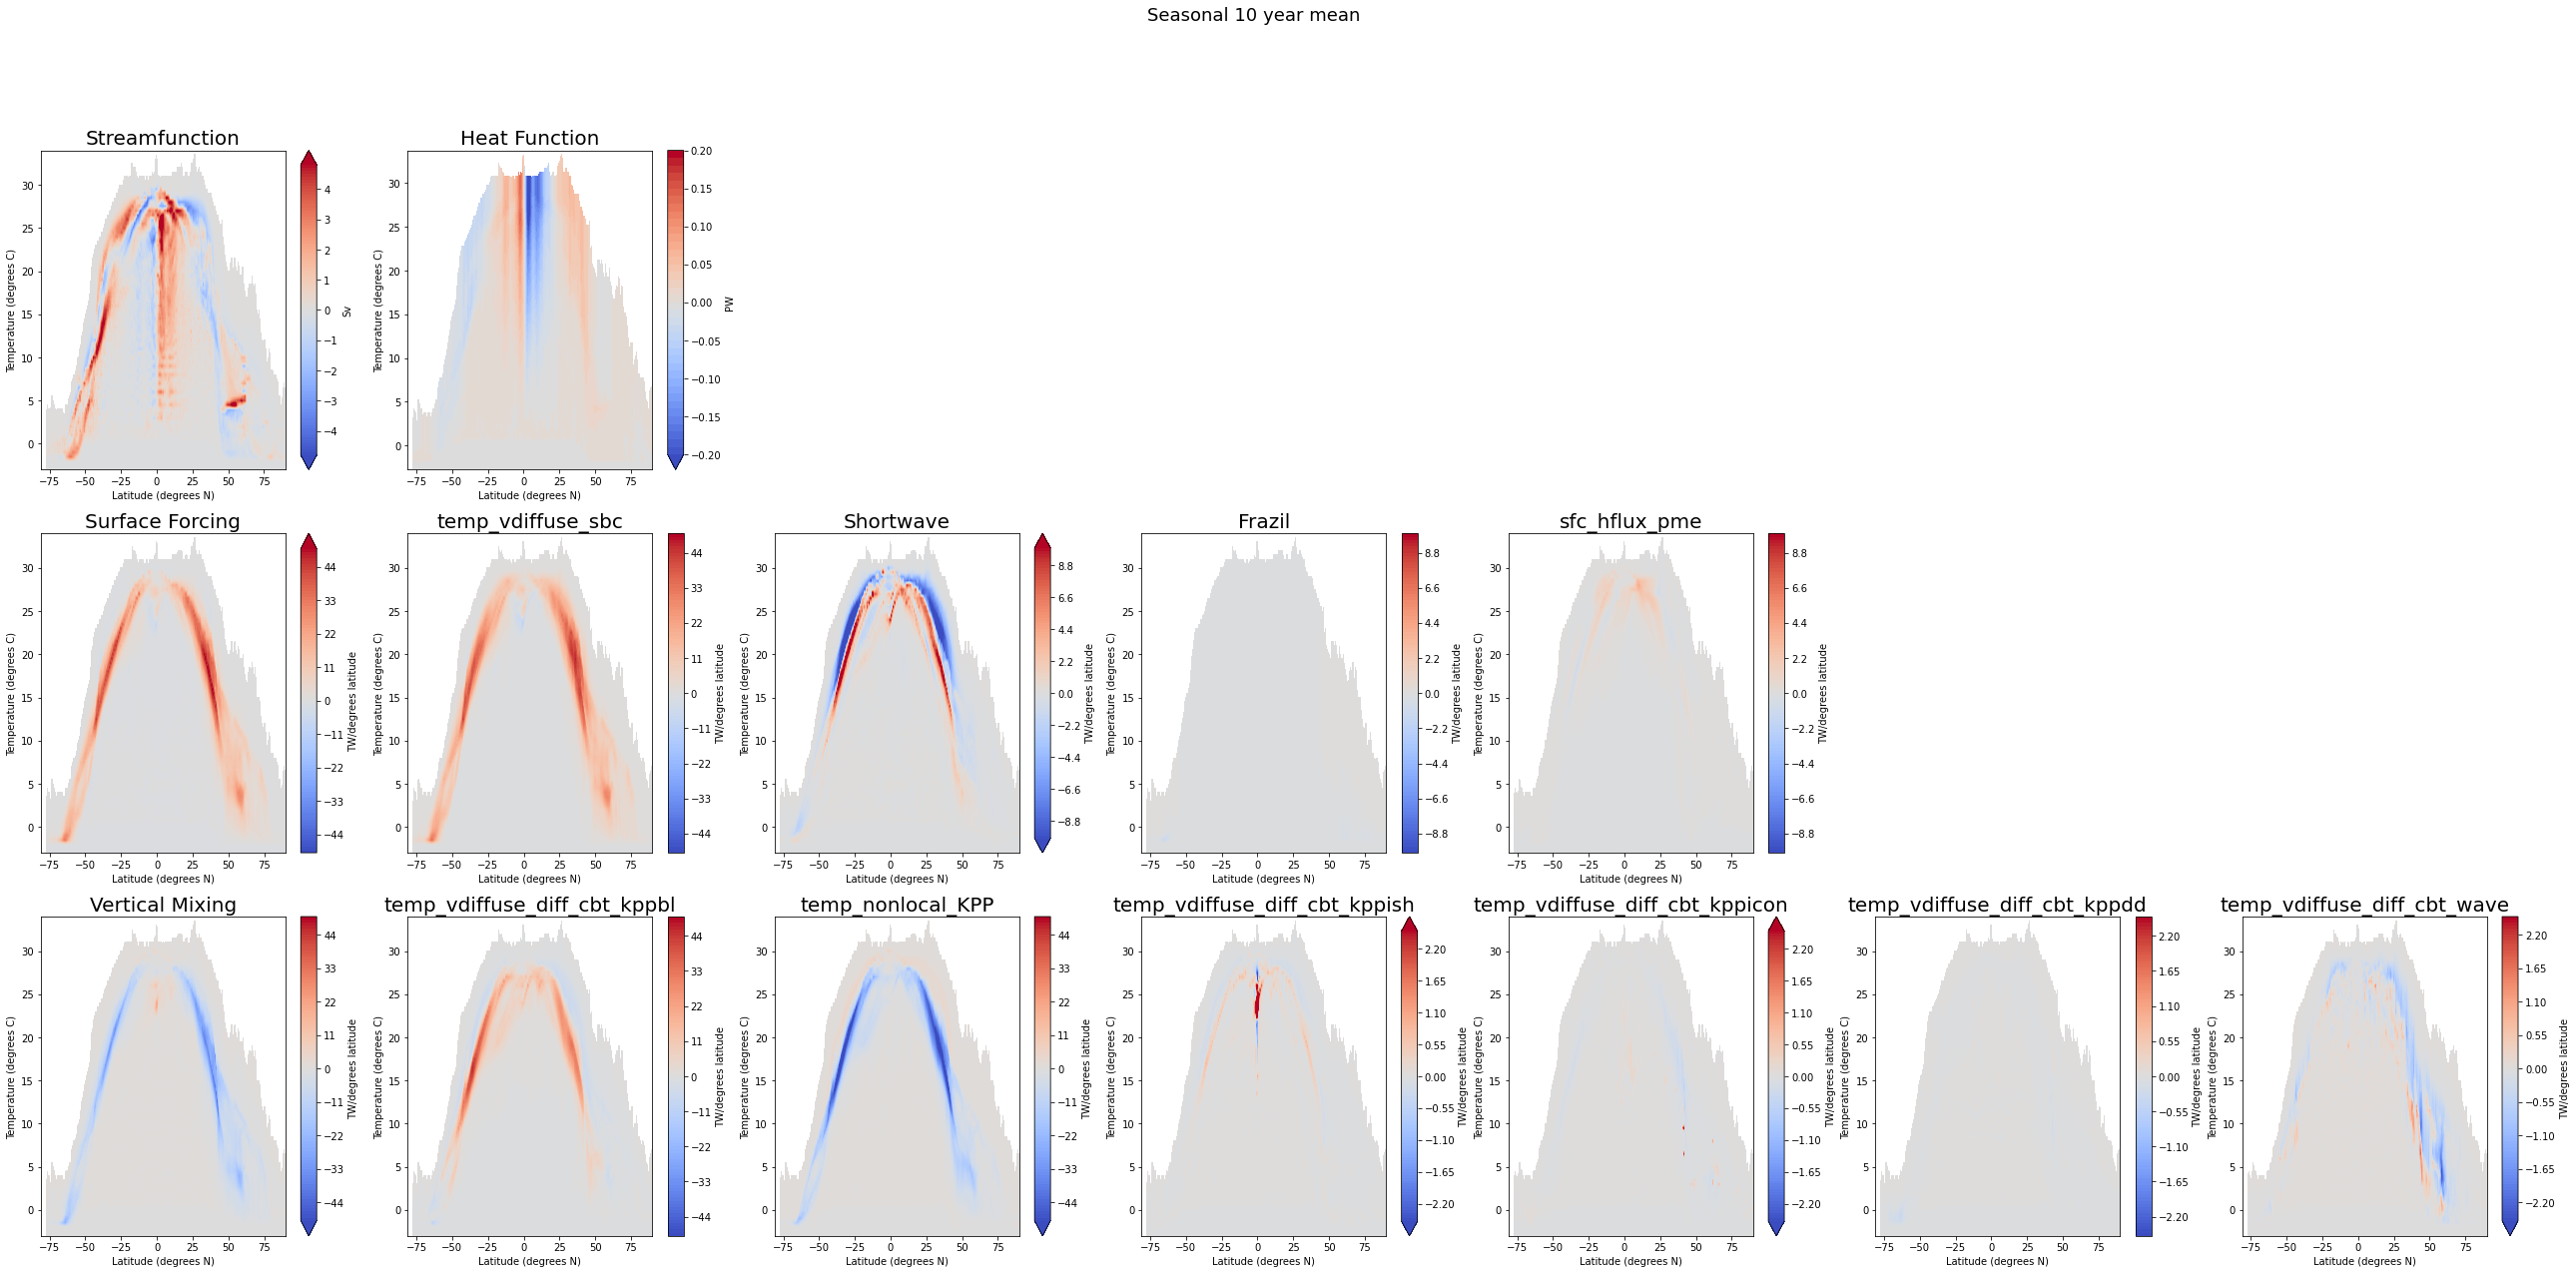

In [8]:
DataSet = sc_Twomo_mean_10year_means - Mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-24.,24.5,0.5)/5
Hfcbar = np.arange(-1.,1.05,0.05)/5
SFcbar = np.arange(-50.,51.,1.)
MXcbar = np.arange(-50.,51.,1.)

cmap = 'coolwarm'

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/20,  'Seasonal 10 year mean')

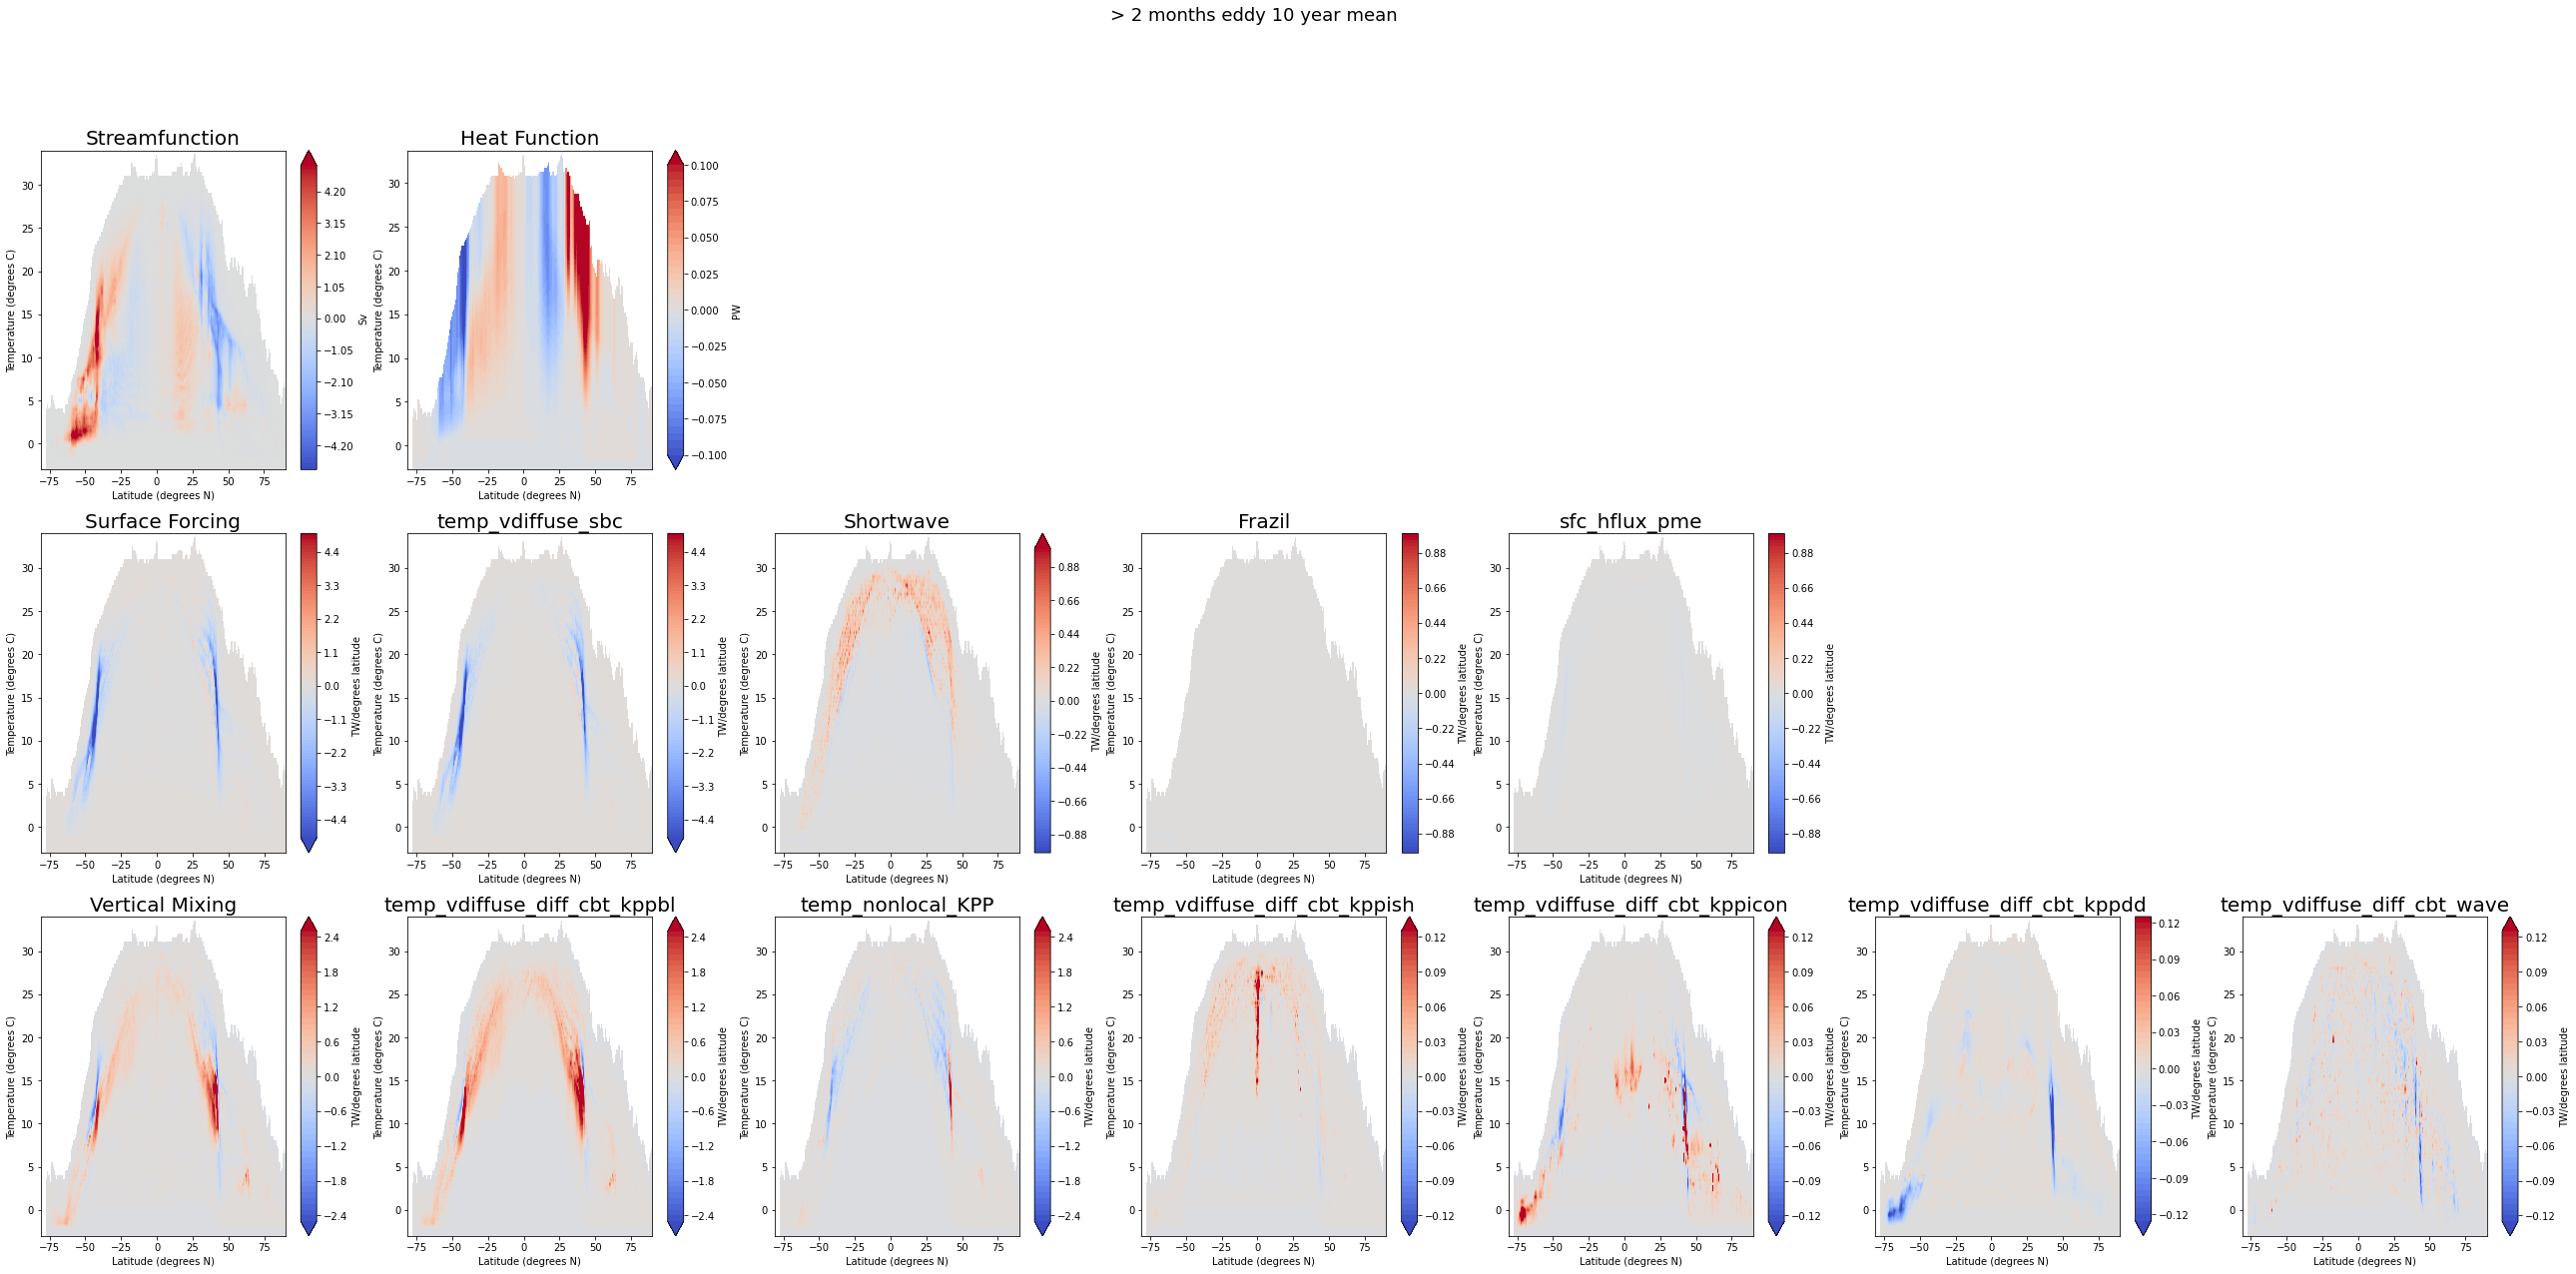

In [9]:
DataSet = Twomo_mean_10year_means - sc_Twomo_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

cmap = 'coolwarm'

plot_decomp_3d_to_2d(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/20,  '> 2 months eddy 10 year mean')

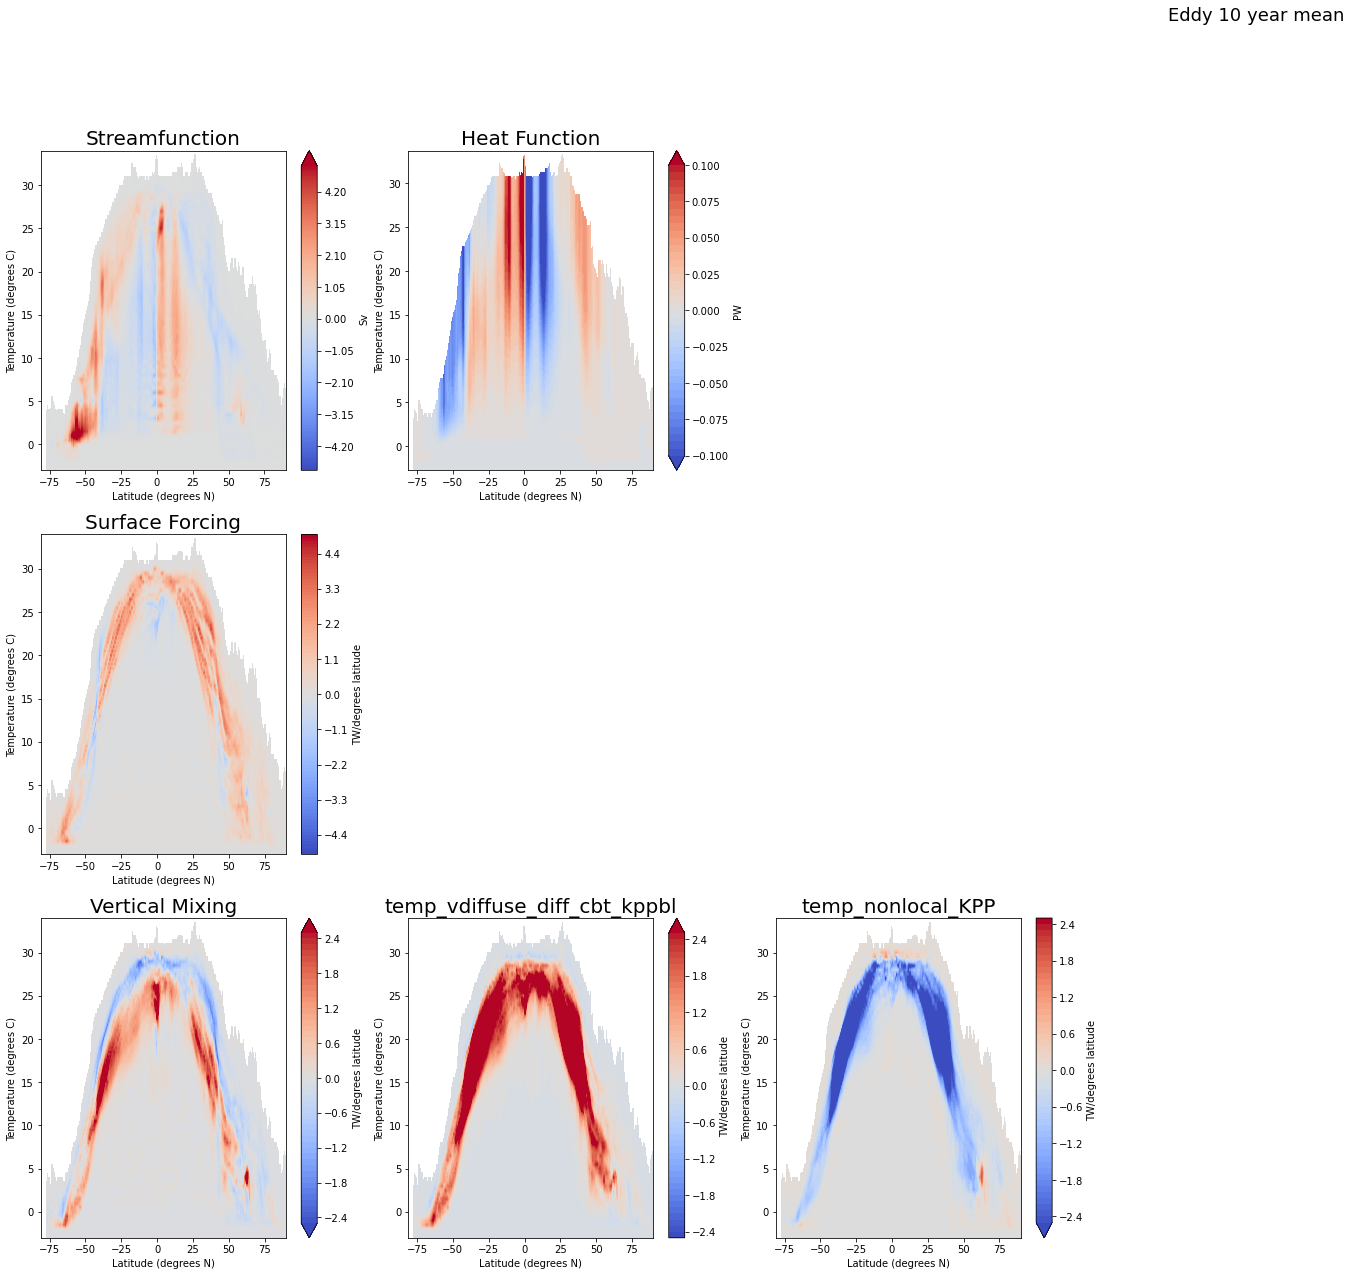

In [22]:
DataSet = Twomo_mean_10year_means 
b = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
       DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
       DataSet.temp_vdiffuse_diff_cbt_kppish

Twomo_mean_10year_means['temp_nonlocal_KPP'] = b

DataSet = Tenday_mean_10year_means - Twomo_mean_10year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)
Hfcbar = np.arange(-0.1,0.105,0.005)
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-2.5,2.51,0.1)

plot_decomp_3d_to_2d_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/10,  'Eddy 10 year mean')

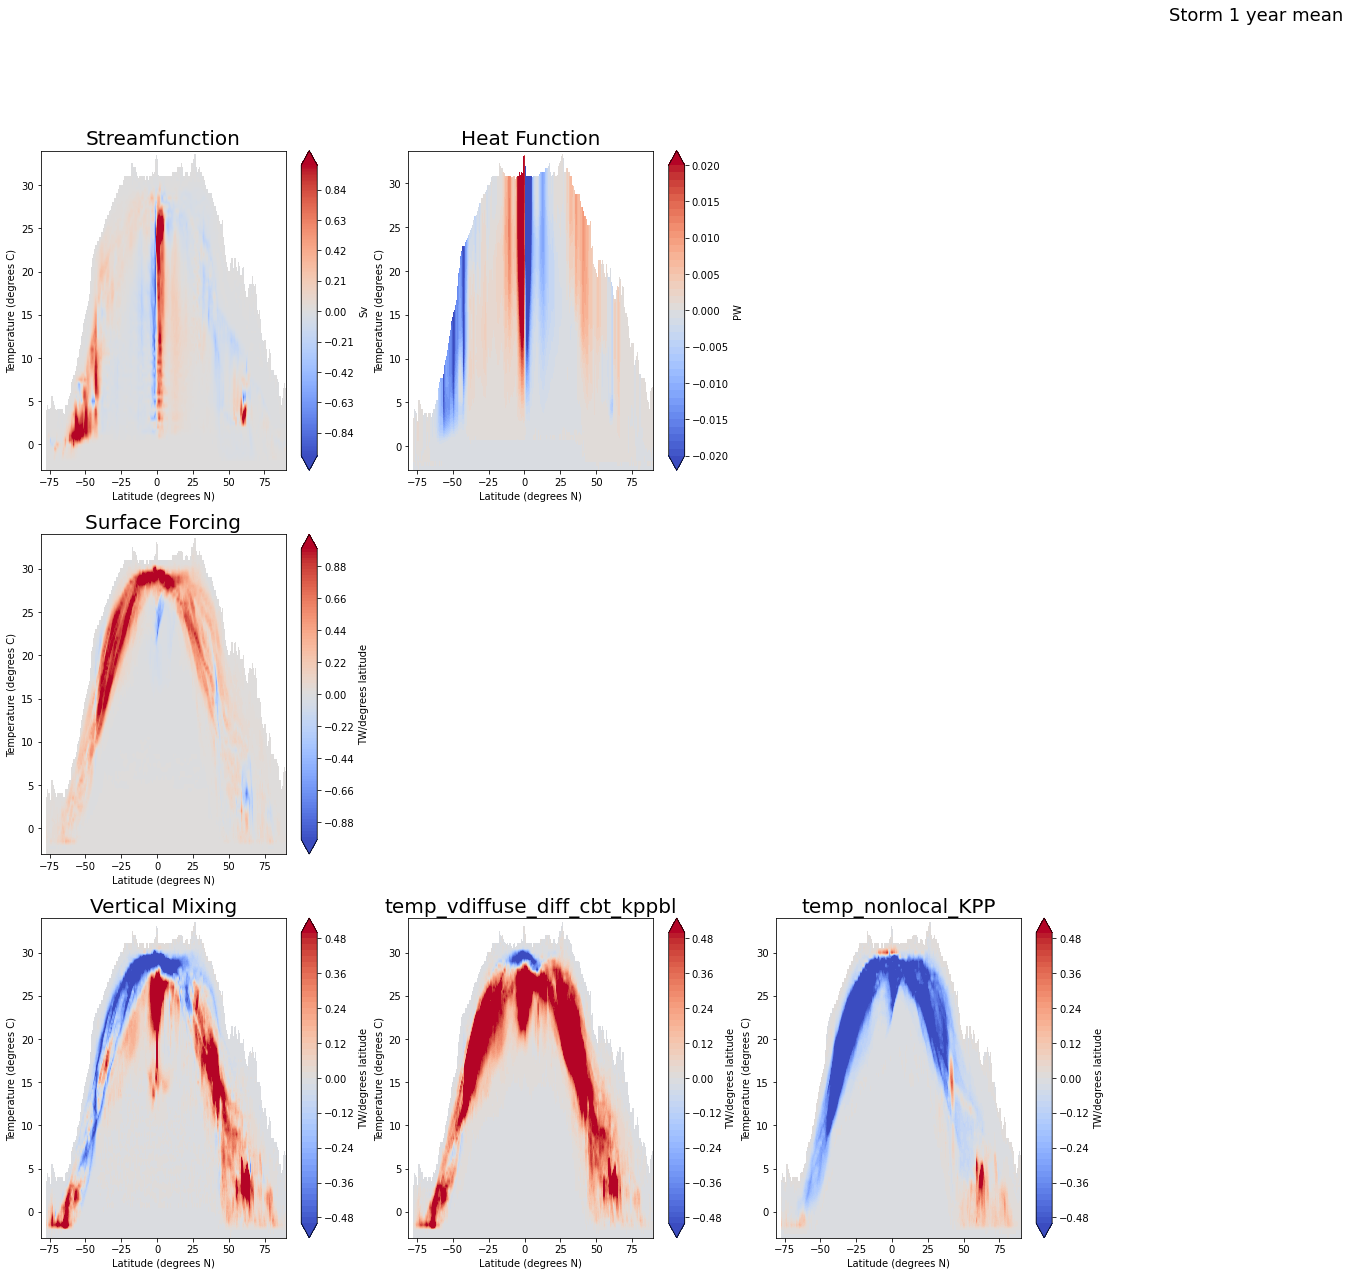

In [23]:
DataSet = Oneday_mean_10year_means - Tenday_mean_10year_means
Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/5
Hfcbar = np.arange(-0.1,0.105,0.005)/5
SFcbar = np.arange(-5.,5.1,0.1)/5
MXcbar = np.arange(-2.5,2.51,0.1)/5

plot_decomp_3d_to_2d_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/10,  'Storm 1 year mean')

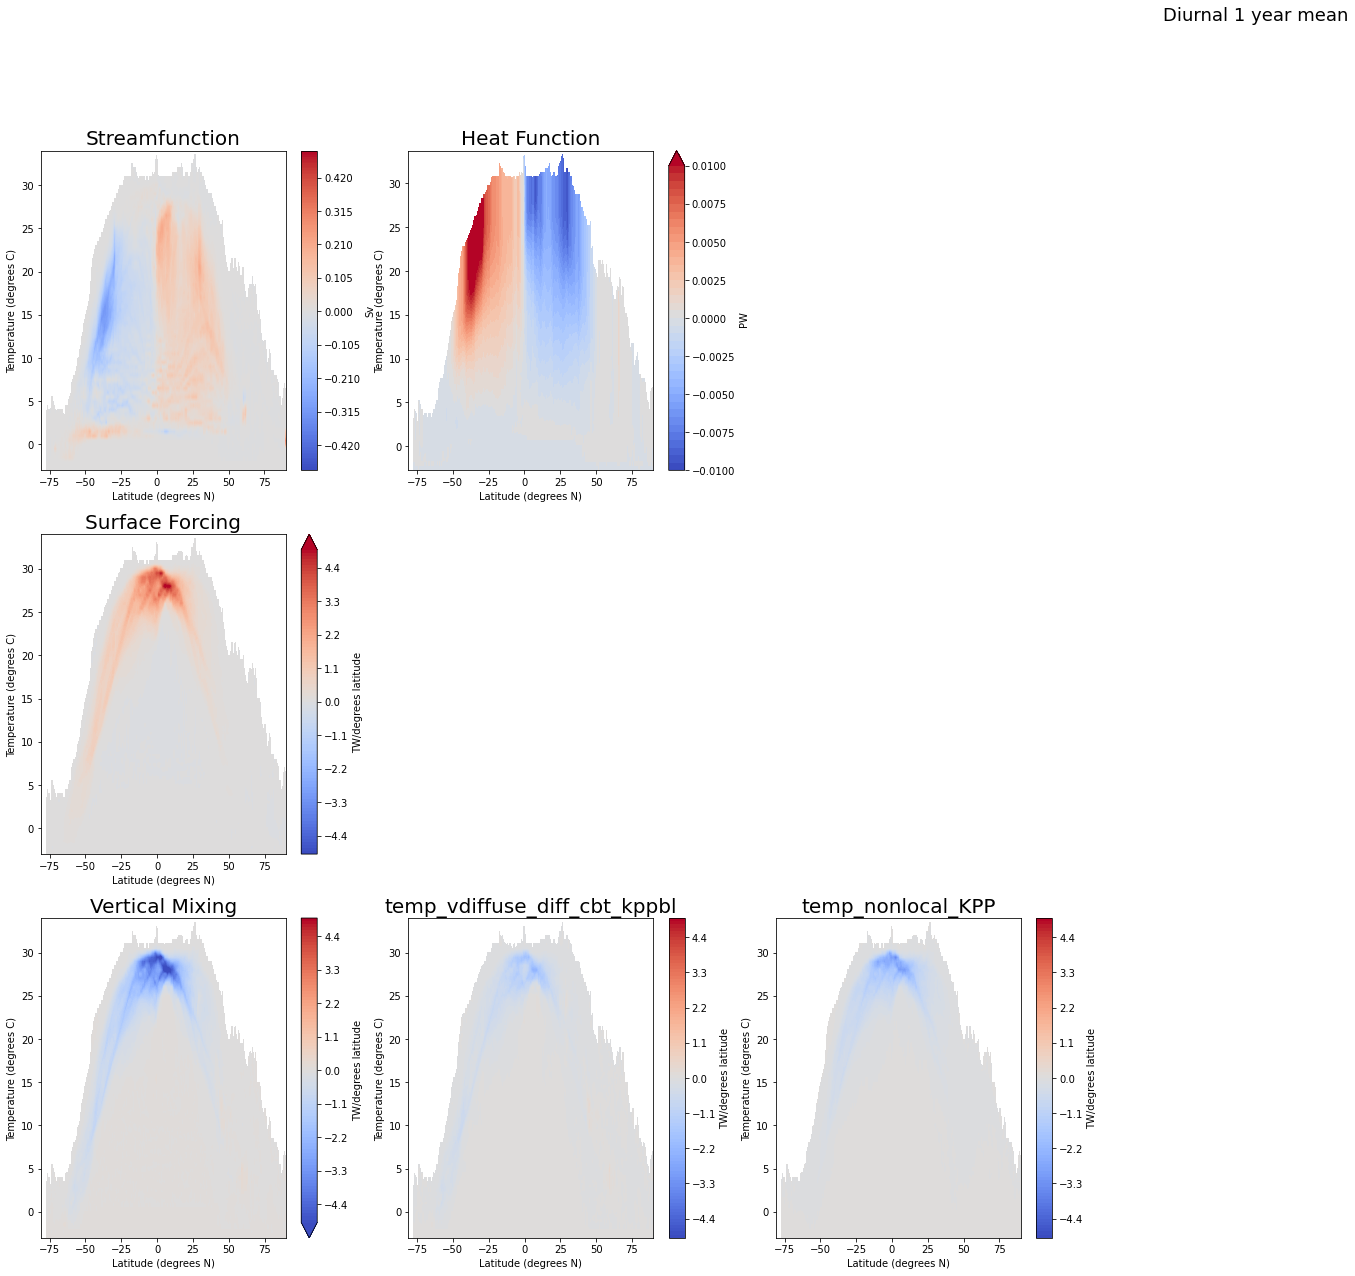

In [24]:
DataSet =  True_10year_means - Oneday_mean_10year_means

Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

Psicbar = np.arange(-5.,5.1,0.05)/10
Hfcbar = np.arange(-0.1,0.105,0.005)/10
SFcbar = np.arange(-5.,5.1,0.1)
MXcbar = np.arange(-5.,5.1,0.1)

plot_decomp_3d_to_2d_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar,SFcbar/5, MXcbar/10,  'Diurnal 1 year mean')

## Integrate in latitude direction:

(-80.0, 80.0)

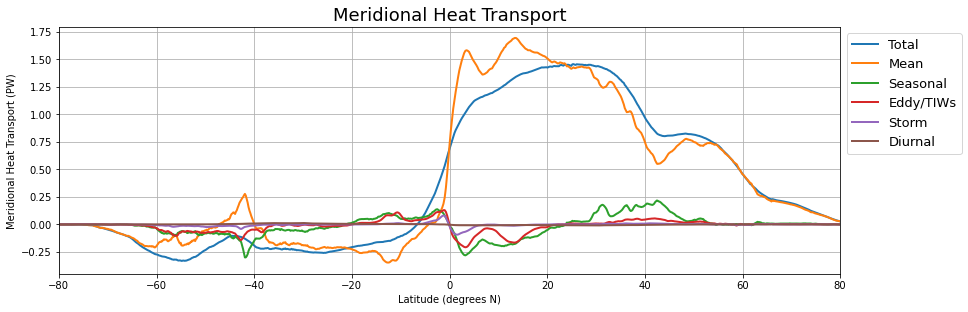

In [20]:
plt.figure(figsize=(14,10))

plt.subplot(2,1,1)
Hf = -Cp*rho0*dT*gridwm.cumsum(True_10year_means.Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)
Hf_mean_tot = -Cp*rho0*dT*gridwm.cumsum(Mean_10year_means.Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)
Hf_ac = -Cp*rho0*dT*gridwm.cumsum((Twomo_mean_10year_means - Mean_10year_means).Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)
Hf_TIWs = -Cp*rho0*dT*gridwm.cumsum((Tenday_mean_10year_means - Twomo_mean_10year_means).Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)
Hf_storm = -Cp*rho0*dT*gridwm.cumsum((Oneday_mean_10year_means- Tenday_mean_10year_means).Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)
Hf_diurnal = -Cp*rho0*dT*gridwm.cumsum((True_10year_means-Oneday_mean_10year_means).Psi.sum('grid_xt_ocean'),'T',boundary="fill", fill_value=0)

(Hf/1.e15).isel(neutral=-1).plot(label='Total',linewidth=2)
(Hf_mean_tot/1.e15).isel(neutral=-1).plot(label='Mean',linewidth=2)
(Hf_ac/1.e15).isel(neutral=-1).plot(label='Seasonal',linewidth=2)
(Hf_TIWs/1.e15).isel(neutral=-1).plot(label='Eddy/TIWs',linewidth=2)
(Hf_storm/1.e15).isel(neutral=-1).plot(label='Storm',linewidth=2)
(Hf_diurnal/1.e15).isel(neutral=-1).plot(label='Diurnal',linewidth=2)

plt.legend(bbox_to_anchor = (1,1),loc='upper left', fontsize = 13)
plt.ylabel('Meridional Heat Transport (PW)')
plt.xlabel('Latitude (degrees N)')
plt.title('Meridional Heat Transport', fontsize = 18)
plt.grid()
plt.xlim([-80.,80.])


## Spatial Maps Integrated Over Temperature

In [25]:
def plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(50,15),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    plt.subplot(3,7,8)
    (DataSet.SF.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,9)
    (DataSet.temp_vdiffuse_sbc.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_sbc', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,10)
    (DataSet.sw_heat.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Shortwave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,11)
    (DataSet.frazil_3d.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Frazil', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,12)
    ((DataSet.SF-DataSet.sw_heat-DataSet.frazil_3d-DataSet.temp_vdiffuse_sbc).sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('sfc_hflux_pme', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,17)
    temp = DataSet.MX-DataSet.temp_vdiffuse_diff_cbt_wave-DataSet.temp_vdiffuse_diff_cbt_kppdd - \
           DataSet.temp_vdiffuse_diff_cbt_kppbl - DataSet.temp_vdiffuse_diff_cbt_kppicon - \
           DataSet.temp_vdiffuse_diff_cbt_kppish
    ((temp).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,18)
    ((DataSet.temp_vdiffuse_diff_cbt_kppish).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppish', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,19)
    ((DataSet.temp_vdiffuse_diff_cbt_kppicon).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppicon', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')


    plt.subplot(3,7,20)
    ((DataSet.temp_vdiffuse_diff_cbt_kppdd).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppdd', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,21)
    ((DataSet.temp_vdiffuse_diff_cbt_wave).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar2,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_wave', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    
    
    plt.suptitle(title, fontsize = 18)
    plt.show()

In [26]:
def plot_decomp_map_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar2, MXcbar2, title):
    
    plt.figure(figsize=(50,15),facecolor='w')
    Hf = -Cp*rho0*dT*gridwm.cumsum(DataSet.Psi,'T',boundary="fill", fill_value=0)

    plt.subplot(3,7,8)
    (DataSet.SF.sum('neutralrho_edges')/1.e12).plot.contourf(levels=SFcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Surface Forcing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')
    
    plt.subplot(3,7,15)
    ((DataSet.MX).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('Vertical Mixing', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,16)
    ((DataSet.temp_vdiffuse_diff_cbt_kppbl).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_vdiffuse_diff_cbt_kppbl', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.subplot(3,7,17)
    temp = DataSet.temp_nonlocal_KPP
    ((temp).sum('neutralrho_edges')/1.e12).plot.contourf(levels=MXcbar,y='grid_yt_ocean',cbar_kwargs={'label':'TW/degrees latitude'},cmap=cmap)
    plt.title('temp_nonlocal_KPP', fontsize = 20)
    plt.ylabel('Latitude (degrees N)')
    plt.xlabel('Longitude (degrees E)')

    plt.suptitle(title, fontsize = 18)
    plt.show()

2023-08-04 15:50:52,929 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 21.94 GiB -- Worker memory limit: 31.25 GiB
2023-08-04 15:50:53,021 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.14 GiB -- Worker memory limit: 31.25 GiB
2023-08-04 15:50:53,122 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 22.03 GiB -- Worker memory limit: 31.25 GiB


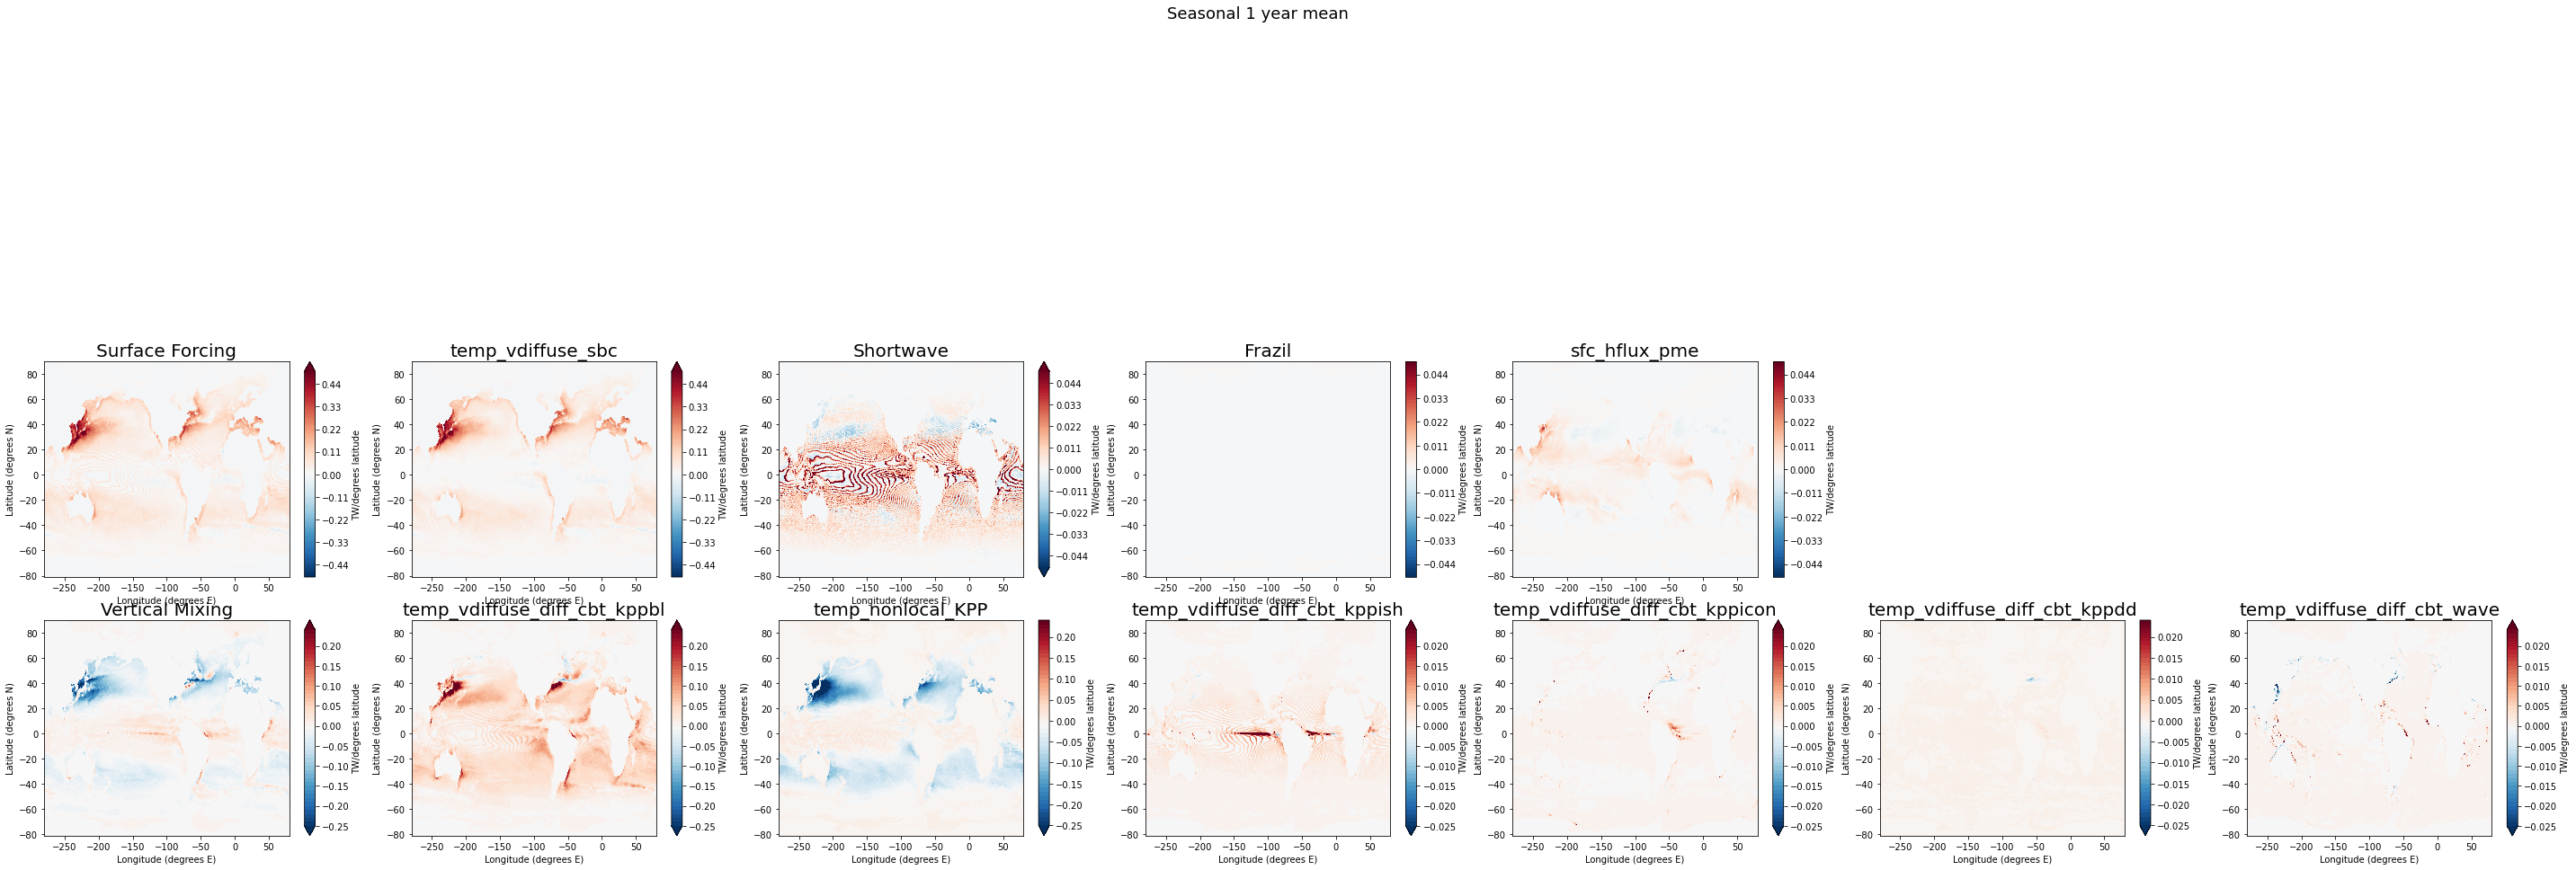

In [27]:
DataSet = Twomo_mean_10year_means - Mean_10year_means

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/100
MXcbar = np.arange(-25.,25.,1.)/100

cmap = 'RdBu_r'

plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/10, MXcbar/10,'Seasonal 1 year mean')

2023-08-04 15:55:06,828 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 21.94 GiB -- Worker memory limit: 31.25 GiB
2023-08-04 15:55:06,921 - distributed.worker_memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 21.98 GiB -- Worker memory limit: 31.25 GiB


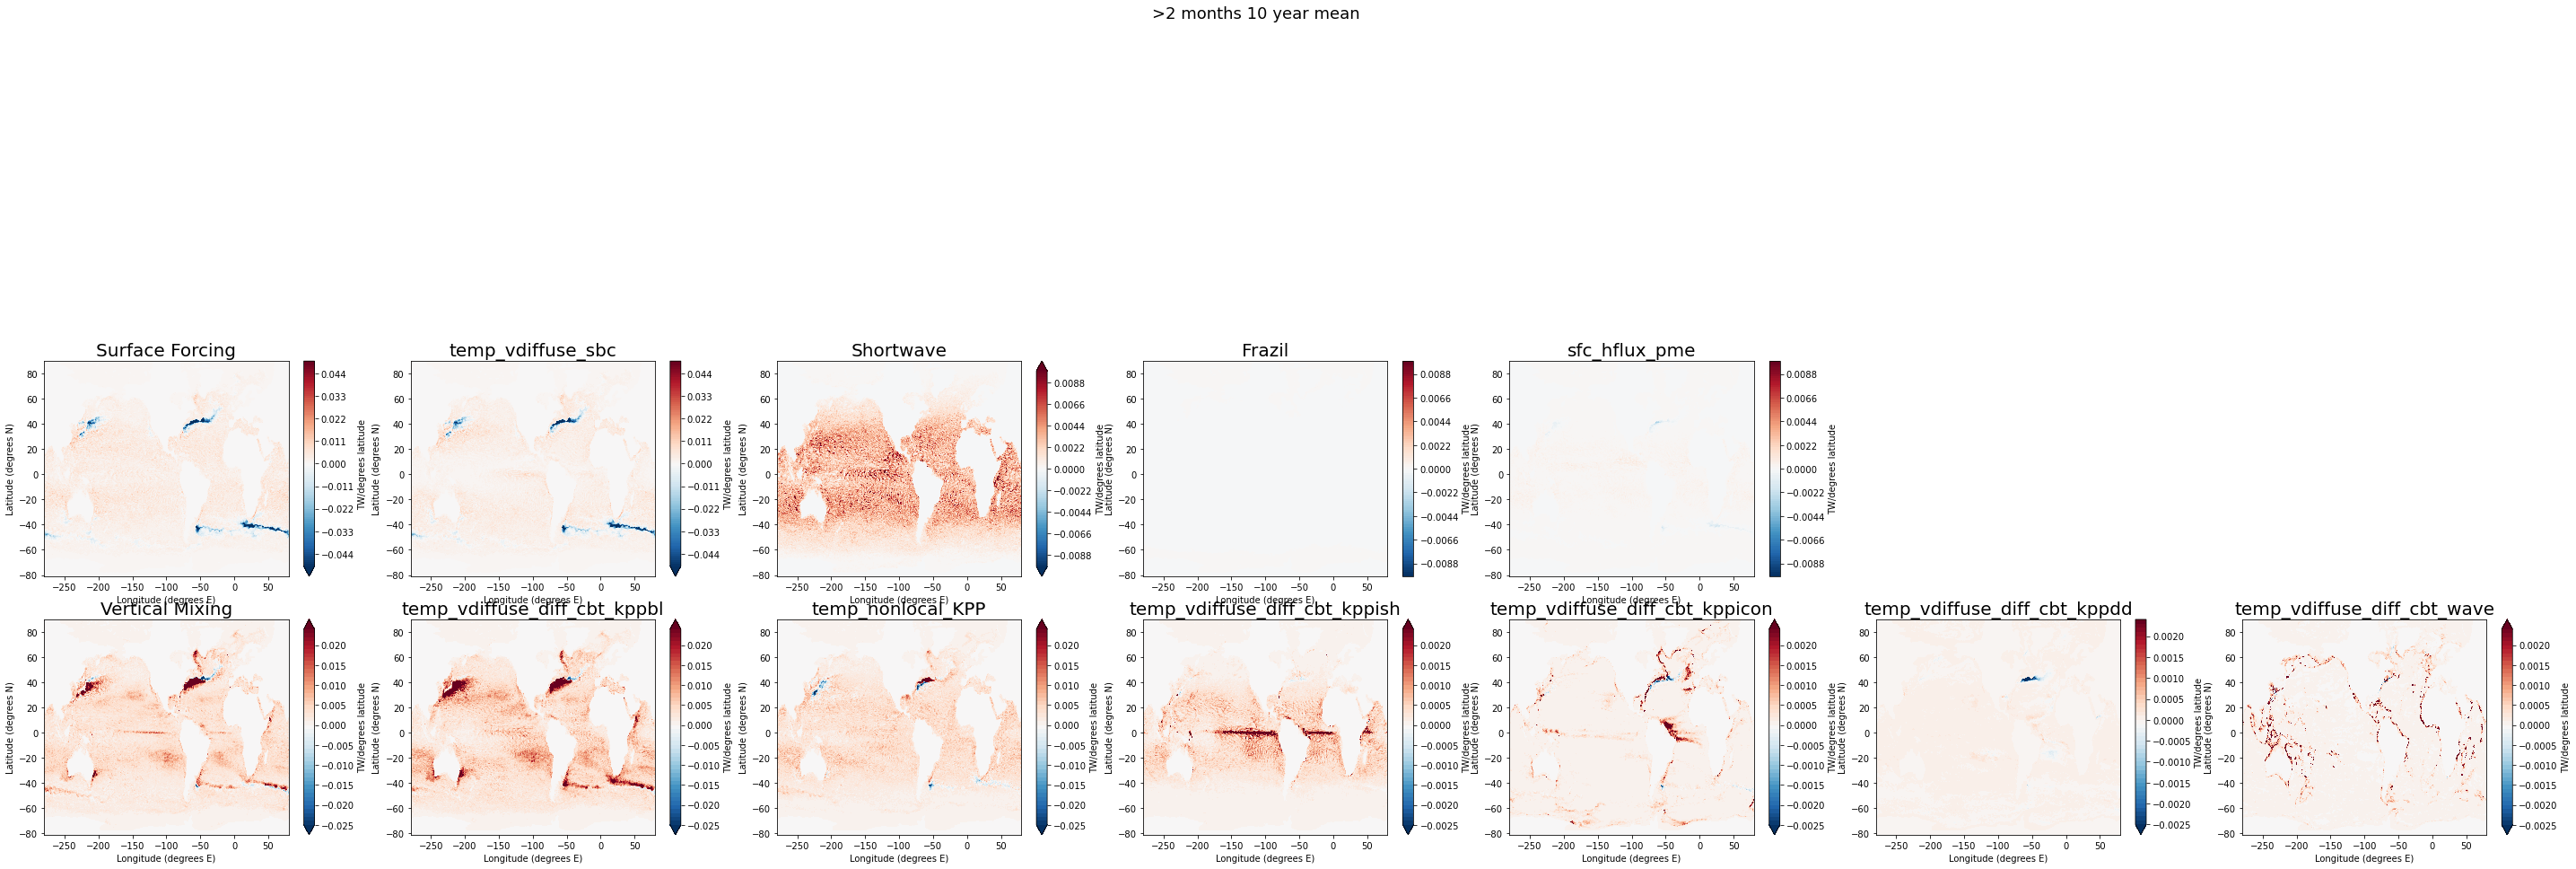

In [28]:
DataSet = Twomo_mean_10year_means - sc_Twomo_mean_10year_means

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/1000
MXcbar = np.arange(-25.,25.,1.)/1000

cmap = 'RdBu_r'

plot_decomp_map(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/5, MXcbar/10,'>2 months 10 year mean')

In [29]:
DataSet = Tenday_mean_10year_means - Twomo_mean_1year_means 

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/1000
MXcbar = np.arange(-25.,25.,1.)/1000

cmap = 'RdBu_r'

plot_decomp_map_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/5, MXcbar/10,'Eddy/TIW 10 year mean')

NameError: name 'Twomo_mean_1year_means' is not defined

In [ ]:
DataSet = Oneday_mean_10year_means  - Tenday_mean_10year_means 

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/1000
MXcbar = np.arange(-25.,25.,1.)/1000

cmap = 'RdBu_r'

plot_decomp_map_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/10, MXcbar/10,'Storm 10 year mean')

In [ ]:
DataSet = True_10year_means - Oneday_mean_10year_means 

Psicbar = np.arange(-24.,24.5,0.5)
Hfcbar = np.arange(-1.,1.05,0.05)
SFcbar = np.arange(-50.,51.,1.)/1000
MXcbar = np.arange(-25.,25.,1.)/1000

cmap = 'RdBu_r'

plot_decomp_map_small(DataSet, Psicbar, Hfcbar, SFcbar, MXcbar, SFcbar/10, MXcbar/10,'Diurnal 10 year mean')

2023-08-04 16:23:48,543 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:48,580 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,003 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,019 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,098 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,104 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,245 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,253 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,491 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,494 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,498 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,635 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,711 - distributed.nanny - WARNING - Restarting worker
2023-08-04 16:23:49,779 - distributed.